# Homework 04. Hyerin Kim (student ID:20185290)
Tree construction of CoV N proteins

## Data files
<ul>
    <li> The genome sequence of Covid-19: '../data/2019nCoV_genomes.2020_04_14.fa'
    <li> The genome information of Covid-19 : '../data/2019nCoV_genomes.2020_04_14.csv'
    <li> The genome sequence of SARS : '../data/SARS_genomes.2020_02_03.fa'
    <li> The genome sequence of MERS : '../data/MERS_genomes.2020_02_03.fa'
    <li> N protein reference sequnece(DNA) : '../data/N_protein_cDNA.fa'
    <li> N protein reference seqeunce(protein) : '../data/N_protein_cDNA_trans.fa'
</ul>
    
## Procedures
<ol>
    <li> Collect CoV N proteins(SARS, MERS, SARS-CoV).
    <li> Select the representative sequences.
    <li> Try both DNA and protein Sequences.
    <li> Do Multiple Sequence Alignment & Phylogeny Construction
</ol>

## Questions
<ol>
    <li> How can you interpret those results?
</ol>

In [1]:
# The function to read sequences from a FASTA file
def read_fasta(tmp_filename):
    rv = dict()
    f = open(tmp_filename, 'r')
    for line in f:
        if line.startswith('>'):
            tmp_h = line.strip().lstrip('>')
            rv[tmp_h] = ''
        else:
            rv[tmp_h] += line.strip().replace(' ', '')
    f.close()
    return rv

In [2]:
# the function to write fasta file
def write_fasta(tmp_filename, gene_list):
    file = open(tmp_filename,"w")
    for key, values in gene_list.items():
        file.write(">"+key+"\n"+values+"\n")
    file.close()

In [3]:
# the function to read GFF information
def read_gff(tmp_filename,keyword):
    location = dict()
    CDS = list()
    gene = list()
    
    f = open(tmp_filename, 'r')
    for line in f:
        if not line.startswith('#') and keyword in line:
            # only apply -1 on start point, because list[0:3] start from point 0 to point 2
            if line.split()[2] == 'CDS':
                CDS.append([int(line.split()[3])-1,int(line.split()[4])])
            elif line.split()[2] == 'gene':
                gene.append([int(line.split()[3])-1,int(line.split()[4])])
            location['CDS'] = CDS
            location['gene'] = gene

    f.close()
    return location

In [4]:
# Read genomes & make N protein cDNA sequence
filename_genomes = '../data/GCF_009858895.2_ASM985889v3_genomic.fna'
genome = read_fasta(filename_genomes)

# get location of N protein cDNA
gff3 = '../data/GCF_009858895.2_ASM985889v3_genomic.gff'
print(read_gff(gff3, 'gene=N'))



{'CDS': [[28273, 29533]], 'gene': [[28273, 29533]]}


In [ ]:
# collect CoV N protein cDNAs from SARS, MERS, SARS-CoV
# to get N protein sequence from updated(04_14) data, 
'''
type on Ubuntu
#for DNA sequence
makeblastdb -dbtype nucl -in 2019nCoV_genomes.2020_04_14.fa -out 2019nCoV_DNA_db

#for protein seqeunce, 
transeq --seqeunce 2019nCoV_genomes.2020_04_14.fa --outseq 2019nCoV_trans6.2020_04_14.fa -frame 6
makeblastdb -dbtype prot -in 2019nCoV_trans6.2020_04_14.fa -out 2019nCoV_protein_db

#for updated nCoV genome data
blastn -db 2019nCoV_DNA_db -query N_protein_cDNA.fa -outfmt 7 -out 2019nCoV_Nprotein_DNA_blastn.nbl
blastp -db 2019nCoV_protein_db -query N_protein_cDNA_trans.fa -outfmt 7 -out 2019nCoV_Nprotein_protein_blastp.tbl

blastn -db SARS_DNA_db -query N_protein_cDNA.fa -outfmt 7 -out SARS_Nprotein_DNA_blastn.nbl
blastp -db SARS_protein_db -query N_protein_cDNA_trans.fa -outfmt 7 -out SARS_Nprotein_prot_blastp.tbl

blastn -db MERS_DNA_db -query N_protein_cDNA.fa -outfmt 7 -out MERS_Nprotein_DNA_blastn.nbl
blastp -db MERS_protein_db -query N_protein_cDNA_trans.fa -outfmt 7 -out MERS_Nprotein_prot_blastp.tbl
'''

In [6]:
# the function to read blastN result
# result
def blastN(tmp_filename):
    result = dict()
    info = list()
    f = open(tmp_filename,'r')
    for line in f:
        if not line.startswith('#'):
            #save the blast result in info = [%identity, s.start, s.end]
            info = [float(line.split()[2]),int(line.split()[8]),int(line.split()[9])]
            #save the blast result in result = {subject acc.ver:info}
            result[line.split()[1]] = info
        info = list()
    f.close()
    return result

In [7]:
#the function to read blastP result
def blastP(tmp_filename):
    result = dict()
    info = list()
    a = 'CDS0'
    f = open(tmp_filename,'r')
    for line in f:
        if not line.startswith('#'):
            info = [float(line.split()[2]),int(line.split()[8]),int(line.split()[9])]
            #save the information of various CDS region
            if line.split()[0] == 'CDS0_1':
                result[line.split()[1]] = info
            if line.split()[0] == 'CDS1_1':
                result[line.split()[1]+' by CDS2'] = info
            if line.split()[0] == 'CDS2_1':
                result[line.split()[1]+' by CDS3'] = info
        info = list()
    f.close()
    return result

In [8]:
# the function to extract DNA or Protein seqeunce
def extract(tmp_filename, result):
    f = open(tmp_filename,'r')
    ext_seq = dict()
    whole = read_fasta(tmp_filename)
    for k, v in result.items():
        for name, seq in whole.items():
            if k in name:
                #save the blast result in info = [%identity, s.start, s.end] v[1]=s.start, v[2]=s.end
                ext_seq[name] = seq[v[1]:v[2]]
    f.close()
    return ext_seq
        
    

In [9]:
#the fucntion which select representative seqeunce in dictionary
def selection(gene_list):
    gene_select = dict()
    for k, v in gene_list.items():
        # repetitive seqeunce are removed
        if v not in gene_select.values():
            gene_select[k] = v
    return gene_select

In [10]:
#make SARS_CoV2 N protein phylogeny tree

#merge the SARS_CoV2
#get blast result by blastN and blastP function
COVID_N_DNA = blastN('../data/2019nCoV_Nprotein_DNA_blastn.nbl')
COVID_N_protein = blastP('../data/2019nCoV_Nprotein_protein_blastp.tbl')

#extract aligned N protein seqeunce from blast by extract fucntion
#extract(template file, blast result)
COVID_N_DNA_ext = extract('../data/2019nCoV_genomes.2020_04_14.fa',COVID_N_DNA)
COVID_N_protein_ext = extract('../data/2019nCoV_trans6.2020_04_14.fa',COVID_N_protein)

#select the representative sequence from extracted seq by selection function
COVID_N_DNA_ext_rep = selection(COVID_N_DNA_ext)
COVID_N_protein_ext_rep = selection(COVID_N_protein_ext)

#make .fas file for muscle run in Ubuntu
write_fasta('../data/COVID_N_DNA_ext.fas',COVID_N_DNA_ext_rep)
write_fasta('../data/COVID_N_protein_ext.fas',COVID_N_protein_ext_rep)


'''
type on Ubuntu

muscle -in COVID_N_DNA_ext.fas -out ../04_Phylogeny/COVID_N_DNA_ext_muscle.fa
muscle -in COVID_N_protein_ext.fas -out ../04_Phylogeny/COVID_N_protein_ext_muscle.fa
'''

'\ntype on Ubuntu\n\nmuscle -in COVID_N_DNA_ext.fas -out ../04_Phylogeny/COVID_N_DNA_ext_muscle.fa\nmuscle -in COVID_N_protein_ext.fas -out ../04_Phylogeny/COVID_N_protein_ext_muscle.fa\n'

In [11]:
#make SARS N protein phylogeny tree

#get blast result by blastN and blastP fucntion 
SARS_N_DNA = blastN('../data/SARS_Nprotein_DNA_blastn.nbl')
SARS_N_protein = blastP('../data/SARS_Nprotein_prot_blastp.tbl')

#extract aligned N protein seqeunce from blast by extract fucntion
#extract(template file, blast result)
SARS_N_DNA_ext = extract('../data/SARS_genomes.2020_02_03.fa',SARS_N_DNA)
SARS_N_protein_ext = extract('../data/SARS_trans6.fa',SARS_N_protein)

#select the representative sequence from extracted seq by selection function
SARS_N_DNA_ext_rep = selection(SARS_N_DNA_ext)
SARS_N_protein_ext_rep = selection(SARS_N_protein_ext)

#make .fas file for muscle run in Ubuntu
write_fasta('../data/SARS_N_DNA_ext.fas',SARS_N_DNA_ext_rep)
write_fasta('../data/SARS_N_protein_ext.fas',SARS_N_protein_ext_rep)

'''
type on Ubuntu

muscle -in SARS_N_DNA_ext.fas -out ../04_Phylogeny/SARS_N_DNA_ext_muscle.fa
muscle -in SARS_N_protein_ext.fas -out ../04_Phylogeny/SARS_N_protein_ext_muscle.fa
'''


'\ntype on Ubuntu\n\nmuscle -in SARS_N_DNA_ext.fas -out ../04_Phylogeny/SARS_N_DNA_ext_muscle.fa\nmuscle -in SARS_N_protein_ext.fas -out ../04_Phylogeny/SARS_N_protein_ext_muscle.fa\n'

In [12]:
#make MERS N protein phylogeny tree

#get blast result by blastP function
MERS_N_protein = blastP('../data/MERS_Nprotein_prot_blastp.tbl')

#extract aligned N protein seqeunce from blast by extract function
#extract(template file, blast result)
MERS_N_protein_ext = extract('../data/MERS_trans6.fa',MERS_N_protein)

#extract aligned N protein DNA sequence from blastp result
MERS_N_DNA_dict = dict()
MERS_genome = read_fasta('../data/MERS_genomes.2020_02_03.fa')
f = open('../data/MERS_Nprotein_prot_blastp.tbl')

#collect MERS N protein cDNA seq from protein seq
for line in f:
    if not line.startswith('#') and line.split()[1][-1:] == '1':
        for k, v in MERS_genome.items():
            if line.split()[1][:-2] in k:
                MERS_N_DNA_dict[k] = v[int(line.split()[8])*3:int(line.split()[9])*3]
    
    if not line.startswith('#') and line.split()[1][-1:] == '2':
        for k, v in MERS_genome.items():
            if line.split()[1][:-2] in k:
                MERS_N_DNA_dict[k] = v[int(line.split()[8])*3+1:int(line.split()[9])*3+1]
    
    if not line.startswith('#') and line.split()[1][-1:] == '3':
        for k, v in MERS_genome.items():
            if line.split()[1][:-2] in k:
                MERS_N_DNA_dict[k] = v[int(line.split()[8])*3+2:int(line.split()[9])*3+2]

#select the representative sequence from extracted seq by selection function
MERS_N_DNA_ext_rep = selection(MERS_N_DNA_dict)
MERS_N_protein_ext_rep = selection(MERS_N_protein_ext)


#make .fas file for muscle run in Ubuntu
write_fasta('../data/MERS_N_DNA_ext.fas',MERS_N_DNA_ext_rep)
write_fasta('../data/MERS_N_protein_ext.fas',MERS_N_protein_ext_rep)

'''
type on Ubuntu

muscle -in MERS_N_DNA_ext.fas -out ../04_Phylogeny/MERS_N_DNA_ext_muscle.fa
muscle -in MERS_N_protein_ext.fas -out ../04_Phylogeny/MERS_N_protein_ext_muscle.fa
'''

116


'\ntype on Ubuntu\n\nmuscle -in MERS_N_DNA_ext.fas -out ../04_Phylogeny/MERS_N_DNA_ext_muscle.fa\nmuscle -in MERS_N_protein_ext.fas -out ../04_Phylogeny/MERS_N_protein_ext_muscle.fa\n'

In [21]:
def notation(tmp_filenames,note):
    fa_dict = read_fasta(tmp_filenames)
    fa_note = dict()
    for k, v in fa_dict.items():
        fa_note[note +k] = v
    return fa_note

In [24]:
# add species notation to the keys from extracted files
COVID_N_DNA_not = notation('COVID_N_DNA_ext_muscle.fa','COVID19_')
COVID_N_protein_not = notation('COVID_N_protein_ext_muscle.fa','COVID19_')

MERS_N_DNA_not = notation('MERS_N_DNA_ext_muscle.fa','MERS_')
MERS_N_protein_not = notation('MERS_N_protein_ext_muscle.fa','MERS_')

SARS_N_DNA_not = notation('SARS_N_DNA_ext_muscle.fa','SARS_')
SARS_N_protein_not = notation('SARS_N_protein_ext_muscle.fa','SARS_')

write_fasta('COVID_N_DNA_notation.fa',COVID_N_DNA_not)
write_fasta('COVID_N_protein_notation.fa',COVID_N_protein_not)

write_fasta('MERS_N_DNA_notation.fa',MERS_N_DNA_not)
write_fasta('MERS_N_protein_notation.fa',MERS_N_protein_not)

write_fasta('SARS_N_DNA_notation.fa',SARS_N_DNA_not)
write_fasta('SARS_N_protein_notation.fa',SARS_N_protein_not)


## Results and discussion
<ul>
    <li> COVID19 N protein is more closed to SARS rather than MERS.
    <li> COVID19 N protein is not much developed(mutated), because 500 COVID19 show completly same DNA and protein seqeunce of N protein among 796 types of COVID19.
    <li> MERS has more variable type of N protein rather than COVID19 and SARS. 
    <li> DNA sequences of N protein is more variable rather than proteins in MERS and SARS. these differences are due to the codon system, different combination of 3 nucleotide can encode same amino acid.
</ul>

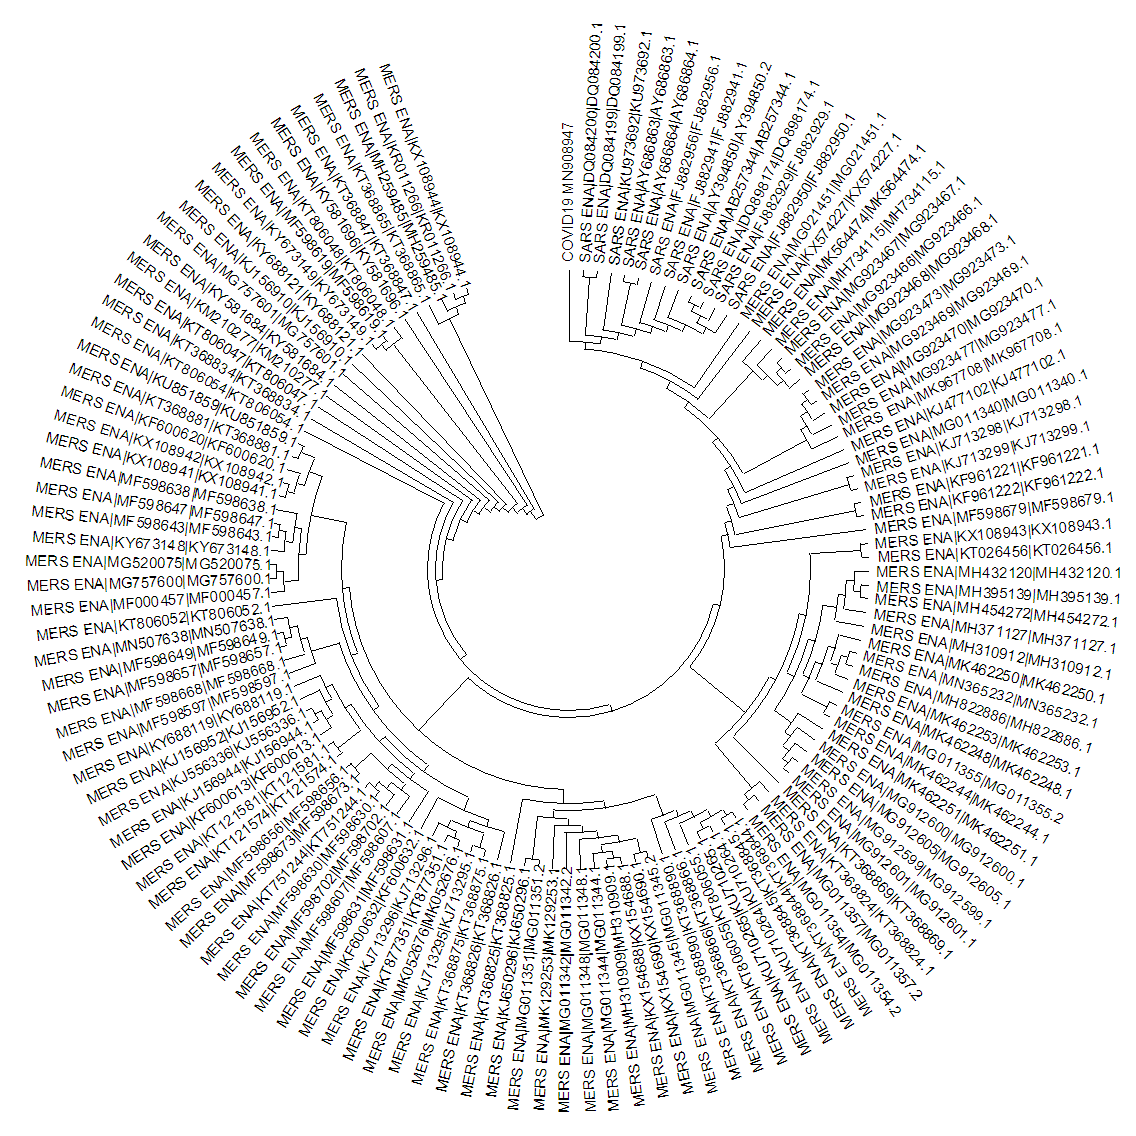

In [11]:
#N protein phylogeny tree (SARS, MERS, COVID19)
from IPython.display import Image
Image(filename="N_protein_tree_circle.png",width=700,height=700)


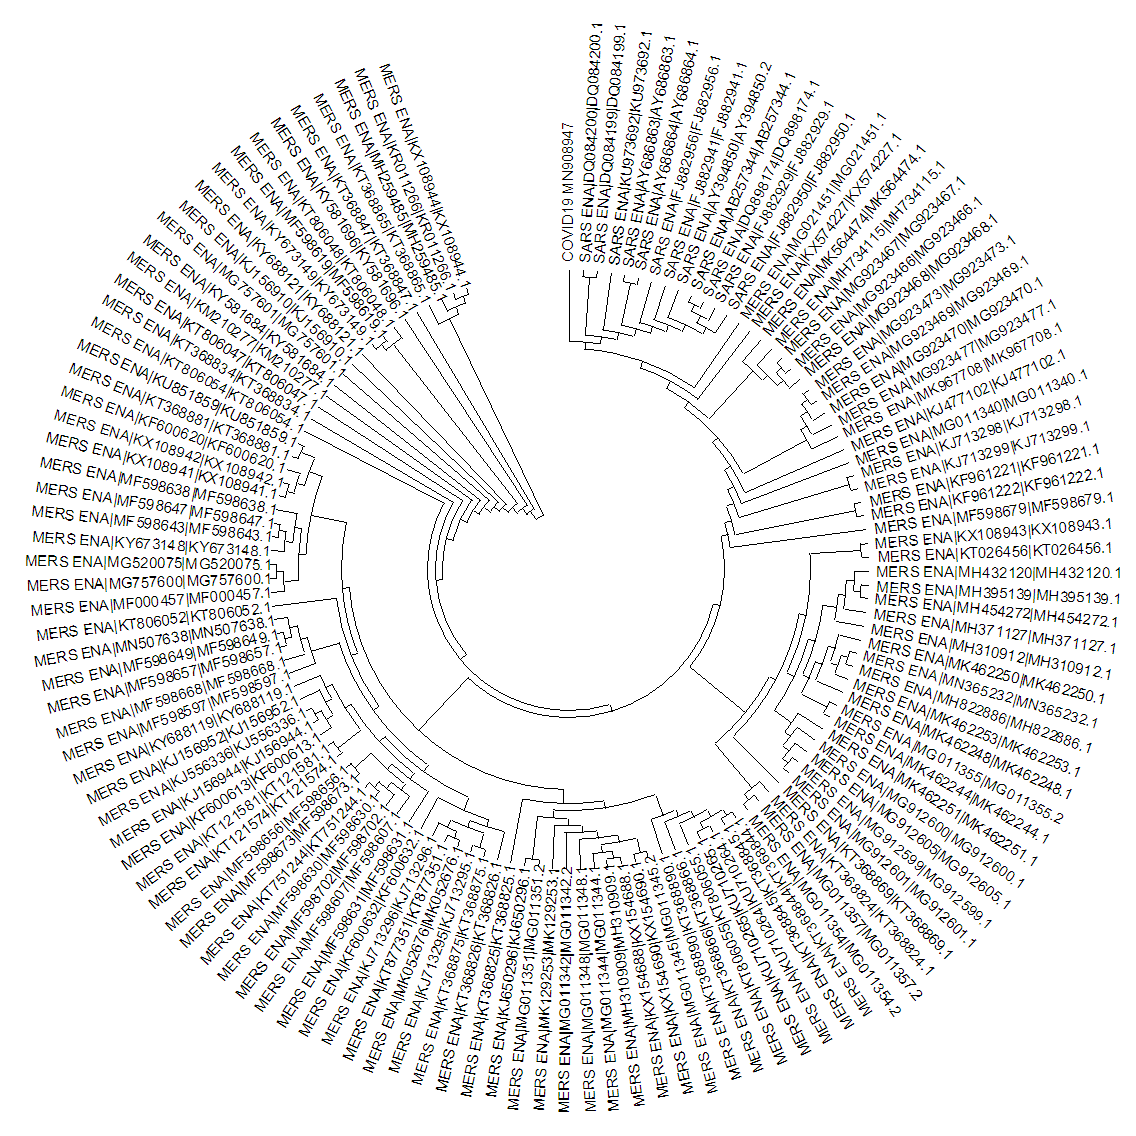

In [12]:
#N cDNA phylogeny tree (SARS, MERS, COVID19)
Image(filename="N_DNA_tree_circle.png",width=700,height=700)

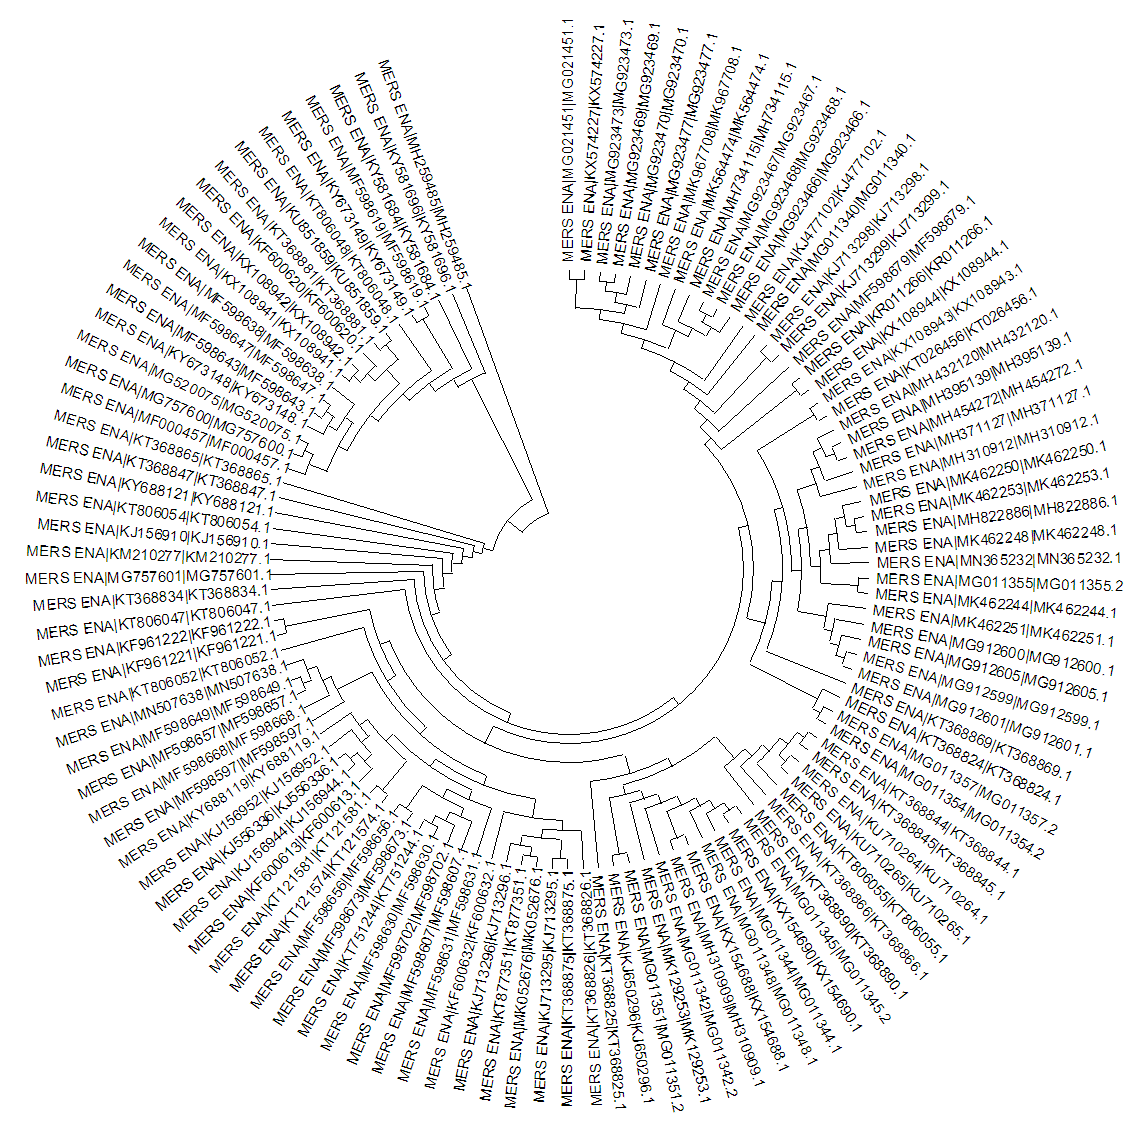

In [14]:
#N cDNA phylogeny tree (MERS)
Image(filename="N_DNA_tree_MERS_circle.png",width=700,height=700)

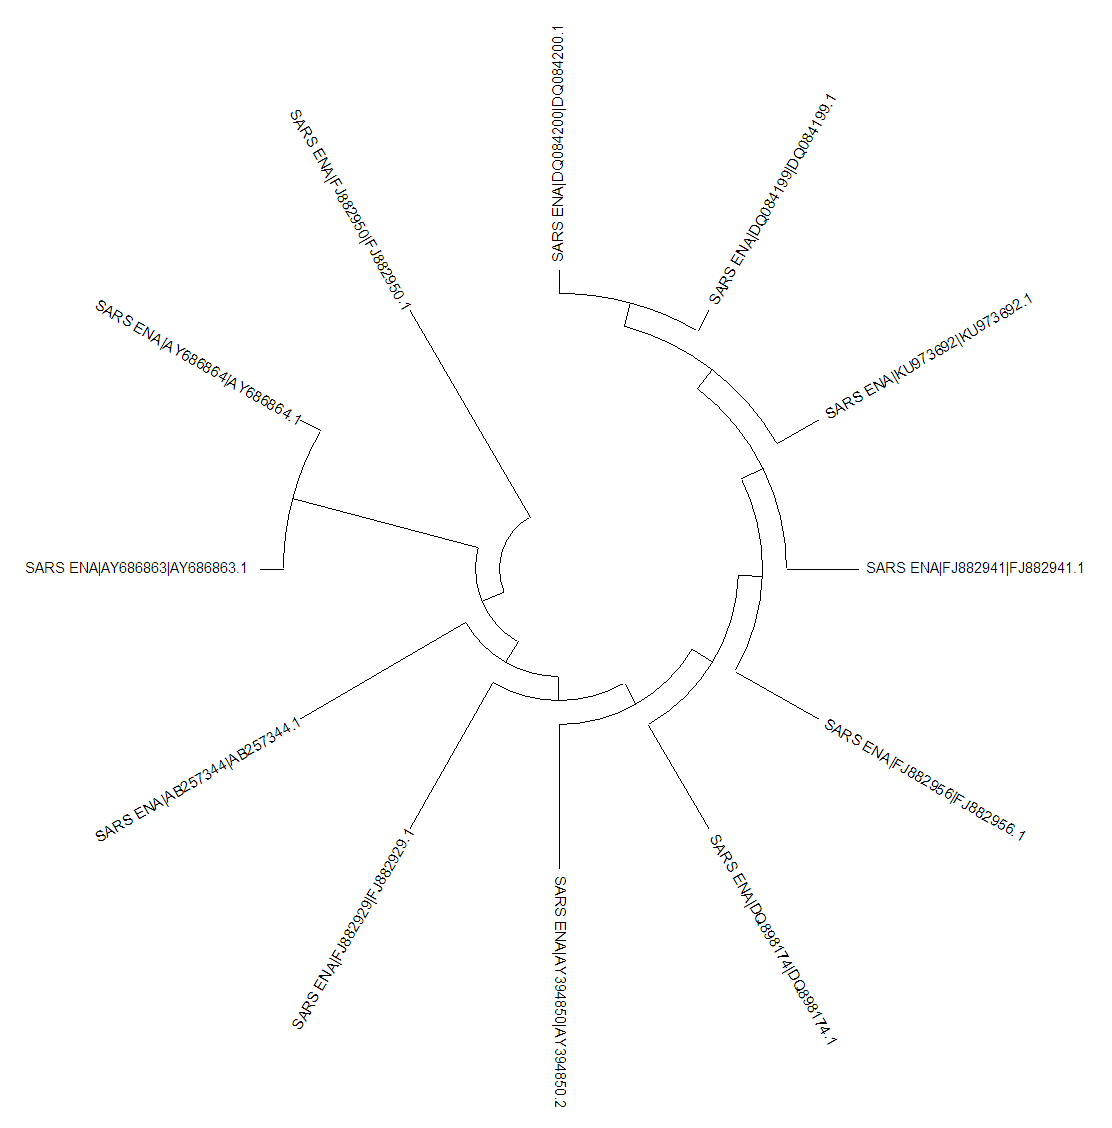

In [15]:
#N cDNA phylogeny tree (SARS)
Image(filename="N_DNA_tree_SARS_circle.png",width=700,height=700)